# Save to Feature Store with a SageMaker Processing Job

<div class="alert alert-info"> 💡 <strong> Quick Start </strong>
To save your processed data to feature store, <strong><a style="color: #0397a7 " href="#Create-Feature-Group">
    <u>Click here to create a feature group</u></a> and follow the instruction to run a SageMaker processing job.
</strong>
</div>

This notebook uses Amazon SageMaker Feature Store (Feature Store) to create a feature group, 
executes your data flow `sp_featStore_2025Nov11.flow` on the entire dataset using a SageMaker 
Processing Job and ingest processed data to Feature Store. 

---

## Contents

1. [Create Feature Group](#Create-Feature-Group)
   1. [Define Feature Group](#Define-Feature-Group)
   1. [Configure Feature Group](#Configure-Feature-Group)
   1. [Initialize & Create Feature Group](#Initialize-&-Create-Feature-Group)
1. [Processing Job: Inputs and Outputs](#Inputs-and-Outputs)
1. [Run Processing Job](#Run-Processing-Job)
   1. [Job Configurations](#Job-Configurations)
   1. [Create Processing Job](#Create-Processing-Job)
   1. [Job Status & Output Location](#Job-Status-&-Output-Location)

## Create Feature Group

_What is a feature group_

A single feature corresponds to a column in your dataset. A feature group is a predefined schema for a 
collection of features - each feature in the feature group has a specified data type and name. 
A single record in a feature group corresponds to a row in your dataframe. A feature store is a 
collection of feature groups. To learn more about SageMaker Feature Store, see 
[Amazon Feature Store Documentation](http://docs.aws.amazon.com/sagemaker/latest/dg/feature-store.html).

### Define Feature Group
Select Record identifier and Event time feature name. These are required parameters for feature group
creation.
* **Record identifier name** is the name of the feature defined in the feature group's feature definitions 
whose value uniquely identifies a Record defined in the feature group's feature definitions.
* **Event time feature name** is the name of the EventTime feature of a Record in FeatureGroup. An EventTime 
is a timestamp that represents the point in time when a new event occurs that corresponds to the creation or 
update of a Record in the FeatureGroup. All Records in the FeatureGroup must have a corresponding EventTime.

<div class="alert alert-info"> 💡Record identifier and Event time feature name are required 
for feature group. After filling in the values, you can choose <b>Run Selected Cell and All Below</b> 
from the Run Menu from the menu bar. 
</div>

In [1]:
record_identifier_feature_name = "custid"
if record_identifier_feature_name is None:
   raise SystemExit("Select a column name as the feature group record identifier.")

event_time_feature_name = "lastorder"
if event_time_feature_name is None:
   raise SystemExit("Select a column name as the event time feature name.")

### Feature Definitions
The following is a list of the feature names and feature types of the final dataset that will be produced 
when your data flow is used to process your input dataset. These are automatically generated from the 
step `Custom Pyspark` from `Source: Answers.Csv`. To save from a different step, go to Canvas to 
select a new step to export.

<div class="alert alert-info"> 💡 <strong> Configurable Settings </strong>

1. You can select a subset of the features. By default all columns of the result dataframe will be used as 
features.
2. You can change the Canvas data type to one of the Feature Store supported types 
(<b>Integral</b>, <b>Fractional</b>, or <b>String</b>). The default type is set to <b>String</b>. 
This means that, if a column in your dataset is not a <b>float</b> or <b>long</b> type, it will default 
to <b>String</b> in your Feature Store.

For <b>Event Time</b> features, make sure the format follows the feature store
<strong>
    <a style="color: #0397a7 " href="https://docs.aws.amazon.com/sagemaker/latest/dg/feature-store-quotas.html#feature-store-data-types">
    <u>Event Time feature format</u>
    </a>
</strong>
</div>

The following is a list of the feature names and data types of the final dataset that will be produced when your data flow is used to process your input dataset.

In [2]:
column_schemas = [
    {
        "name": "retained",
        "type": "long"
    },
    {
        "name": "custid",
        "type": "float"
    },
    {
        "name": "created",
        "type": "datetime"
    },
    {
        "name": "firstorder",
        "type": "datetime"
    },
    {
        "name": "lastorder",
        "type": "datetime"
    },
    {
        "name": "esent",
        "type": "long"
    },
    {
        "name": "eopenrate",
        "type": "float"
    },
    {
        "name": "eclickrate",
        "type": "float"
    },
    {
        "name": "avgorder",
        "type": "float"
    },
    {
        "name": "ordfreq",
        "type": "float"
    },
    {
        "name": "paperless",
        "type": "long"
    },
    {
        "name": "refill",
        "type": "long"
    },
    {
        "name": "doorstep",
        "type": "long"
    },
    {
        "name": "favday",
        "type": "float"
    },
    {
        "name": "city",
        "type": "float"
    }
]

Below we create the SDK input for those feature definitions. Some schema types in Canvas are not 
supported by Feature Store. The following will create a default_FG_type set to String for these types.

In [3]:
from sagemaker.feature_store.feature_definition import FeatureDefinition
from sagemaker.feature_store.feature_definition import FeatureTypeEnum

default_feature_type = FeatureTypeEnum.STRING
column_to_feature_type_mapping = {
    "float": FeatureTypeEnum.FRACTIONAL,
    "long": FeatureTypeEnum.INTEGRAL
}

feature_definitions = [
    FeatureDefinition(
        feature_name=column_schema['name'], 
        feature_type=column_to_feature_type_mapping.get(column_schema['type'], default_feature_type)
    ) for column_schema in column_schemas
]

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Configure Feature Group

<div class="alert alert-info"> 💡 <strong> Configurable Settings </strong>

1. <b>feature_group_name</b>: name of the feature group.
1. <b>feature_store_offline_s3_uri</b>: SageMaker FeatureStore writes the data in the OfflineStore of a FeatureGroup to a S3 location owned by you.
1. <b>enable_online_store</b>: controls if online store is enabled. Enabling the online store allows quick access to the latest value for a Record via the GetRecord API.
1. <b>iam_role</b>: IAM role for executing the processing job.
</div>

In [4]:
from time import gmtime, strftime
import uuid
import sagemaker 

# Sagemaker session
sess = sagemaker.Session()

# You can configure this with your own bucket name, e.g.
# bucket = <my-own-storage-bucket>
bucket = sess.default_bucket()
print(f"bucket: {bucket}")

# IAM role for executing the processing job.
iam_role = sagemaker.get_execution_role()
print(f"iam_role: {iam_role}")

# flow name and an unique ID for this export (used later as the processing job name for the export)
flow_name = "sp-featStore-2025Nov11"
flow_export_id = f"{strftime('%d-%H-%M-%S', gmtime())}-{str(uuid.uuid4())[:8]}"
flow_export_name = f"flow-{flow_export_id}"

# feature group name, with flow_name and an unique id. You can give it a customized name
feature_group_name = f"FG-{flow_name}-{str(uuid.uuid4())[:8]}"
print(f"Feature Group Name: {feature_group_name}")

# SageMaker FeatureStore writes the data in the OfflineStore of a FeatureGroup to a 
# S3 location owned by you.
feature_store_offline_s3_uri = 's3://' + bucket
print(f"feature_store_offline_s3_uri: {feature_store_offline_s3_uri}")

# controls if online store is enabled. Enabling the online store allows quick access to 
# the latest value for a Record via the GetRecord API.
enable_online_store = True

bucket: sagemaker-us-east-1-417311687551
iam_role: arn:aws:iam::417311687551:role/service-role/AmazonSageMaker-ExecutionRole-20251101T200692
Feature Group Name: FG-sp-featStore-2025Nov11-d73341ef
feature_store_offline_s3_uri: s3://sagemaker-us-east-1-417311687551


### Initialize & Create Feature Group

In [5]:
# Initialize Boto3 session that is required to create feature group
import boto3
from sagemaker.session import Session

region = boto3.Session().region_name
boto_session = boto3.Session(region_name=region)

sagemaker_client = boto_session.client(service_name='sagemaker', region_name=region)
featurestore_runtime = boto_session.client(service_name='sagemaker-featurestore-runtime', region_name=region)

feature_store_session = Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime
)

Feature group is initialized and created below

In [6]:
from sagemaker.feature_store.feature_group import FeatureGroup

feature_group = FeatureGroup(
    name=feature_group_name, sagemaker_session=feature_store_session, feature_definitions=feature_definitions)

feature_group.create(
    s3_uri=feature_store_offline_s3_uri,
    record_identifier_name=record_identifier_feature_name,
    event_time_feature_name=event_time_feature_name,
    role_arn=iam_role,
    enable_online_store=enable_online_store
)

{'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:417311687551:feature-group/FG-sp-featStore-2025Nov11-d73341ef',
 'ResponseMetadata': {'RequestId': 'fbfbf8a8-ac63-4090-b4a5-609e7ba98040',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'fbfbf8a8-ac63-4090-b4a5-609e7ba98040',
   'strict-transport-security': 'max-age=47304000; includeSubDomains',
   'x-frame-options': 'DENY',
   'content-security-policy': "frame-ancestors 'none'",
   'cache-control': 'no-cache, no-store, must-revalidate',
   'x-content-type-options': 'nosniff',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '111',
   'date': 'Tue, 02 Dec 2025 01:27:26 GMT'},
  'RetryAttempts': 0}}

Invoke the Feature Store API to create the feature group and wait until it is ready

In [7]:
import time
def wait_for_feature_group_creation_complete(feature_group):
    """Helper function to wait for the completions of creating a feature group"""
    response = feature_group.describe()
    status = response.get("FeatureGroupStatus")
    while status == "Creating":
        print("Waiting for Feature Group Creation")
        time.sleep(5)
        response = feature_group.describe()
        status = response.get("FeatureGroupStatus")

    if status != "Created":
        print(f"Failed to create feature group, response: {response}")
        failureReason = response.get("FailureReason", "")
        raise SystemExit(
            f"Failed to create feature group {feature_group.name}, status: {status}, reason: {failureReason}"
        )
    print(f"FeatureGroup {feature_group.name} successfully created.")

wait_for_feature_group_creation_complete(feature_group=feature_group)

Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
FeatureGroup FG-sp-featStore-2025Nov11-d73341ef successfully created.


Now that the feature group is created, You will use a processing job to process your 
        data at scale and ingest the transformed data into this feature group.

# Inputs and Outputs

The below settings configure the inputs and outputs for the flow export.

<div class="alert alert-info"> 💡 <strong> Configurable Settings </strong>

In <b>Input - Source</b> you can configure the data sources that will be used as input by Canvas

1. For S3 sources, configure the source attribute that points to the input S3 prefixes
2. For all other sources, configure attributes like query_string, database in the source's 
<b>DatasetDefinition</b> object.

If you modify the inputs the provided data must have the same schema and format as the data used in the Flow. 
You should also re-execute the cells in this section if you have modified the settings in any data sources.

Parametrized data sources will be ignored when creating ProcessingInputs, and will directly read from the source.
Network isolation is not supported for parametrized data sources.
</div>

In [8]:
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.dataset_definition.inputs import AthenaDatasetDefinition, DatasetDefinition, RedshiftDatasetDefinition

data_sources = []

## Input - S3 Source: storedata_total-csv-fmt.csv

In [9]:
data_sources.append(ProcessingInput(
    source="s3://amzn-s3-springsource-ml-churn/spring_source/storedata_total-csv-fmt.csv", # You can override this to point to other dataset on S3
    destination="/opt/ml/processing/storedata_total-csv-fmt.csv",
    input_name="storedata_total-csv-fmt.csv",
    s3_data_type="S3Prefix",
    s3_input_mode="File",
    s3_data_distribution_type="FullyReplicated"
))

### Output: Feature Store 

Below are the inputs required by the SageMaker Python SDK to launch a processing job with feature store as an output.

In [10]:
from sagemaker.processing import FeatureStoreOutput

# Output name is auto-generated from the select node's ID + output name from the flow file.
output_name = "2c0a7493-90fc-41a4-b067-bf42659bf1eb.default"

processing_job_output = ProcessingOutput(
    output_name=output_name,
    app_managed=True,
    feature_store_output=FeatureStoreOutput(feature_group_name=feature_group_name),
)

## Upload Flow to S3

To use the data flow as an input to the processing job, first upload your flow file to Amazon S3.

In [11]:
import os
import json
import boto3

# name of the flow file which should exist in the current notebook working directory
flow_file_name = "sp_featStore_2025Nov11.flow"

# Load .flow file from current notebook working directory 
!echo "Loading flow file from current notebook working directory: $PWD"

with open(flow_file_name) as f:
    flow = json.load(f)

# Upload flow to S3
s3_client = boto3.client("s3")
s3_client.upload_file(flow_file_name, bucket, f"data_wrangler_flows/{flow_export_name}.flow", ExtraArgs={"ServerSideEncryption": "aws:kms"})

flow_s3_uri = f"s3://{bucket}/data_wrangler_flows/{flow_export_name}.flow"

print(f"Data flow {flow_file_name} uploaded to {flow_s3_uri}")

Loading flow file from current notebook working directory: /home/sagemaker-user/springboard
Data flow sp_featStore_2025Nov11.flow uploaded to s3://sagemaker-us-east-1-417311687551/data_wrangler_flows/flow-02-01-27-25-85db4acd.flow


The data flow is also provided to the Processing Job as an input source which we configure below.

In [12]:
## Input - Flow: sp_featStore_2025Nov11.flow
flow_input = ProcessingInput(
    source=flow_s3_uri,
    destination="/opt/ml/processing/flow",
    input_name="flow",
    s3_data_type="S3Prefix",
    s3_input_mode="File",
    s3_data_distribution_type="FullyReplicated"
)

# Run Processing Job 
## Job Configurations

<div class="alert alert-info"> 💡 <strong> Configurable Settings </strong>

You can configure the following settings for Processing Jobs. If you change any configurations you will 
need to re-execute this and all cells below it by selecting the Run menu above and click 
<b>Run Selected Cells and All Below</b>

1. IAM role for executing the processing job. 
2. A unique name of the processing job. Give a unique name every time you re-execute processing jobs
3. Canvas Container URL.
4. Instance count, instance type and storage volume size in GB.
5. Content type for each output. Canvas supports CSV as default and Parquet.
6. Network Isolation settings
7. KMS key to encrypt output data
</div>

In [13]:
from sagemaker import image_uris

# IAM role for executing the processing job.
iam_role = sagemaker.get_execution_role()

# Unique processing job name. Give a unique name every time you re-execute processing jobs.
processing_job_name = f"data-wrangler-flow-processing-{flow_export_id}"

# Canvas Container URL.
container_uri = "599662218115.dkr.ecr.us-east-1.amazonaws.com/sagemaker-data-wrangler-container:5.x"
# Pinned Canvas Container URL.
container_uri_pinned = "599662218115.dkr.ecr.us-east-1.amazonaws.com/sagemaker-data-wrangler-container:5.0.9"

# Processing Job Instance count and instance type.
instance_count = 2
instance_type = "ml.t3.xlarge" #"ml.m5.4xlarge"

# Size in GB of the EBS volume to use for storing data during processing.
volume_size_in_gb = 30


# Content type for each output. Canvas supports CSV as default and Parquet.
output_content_type = "CSV"

# Delimiter to use for the output if the output content type is CSV. Uncomment to set.
# delimiter = ","

# Compression to use for the output. Uncomment to set.
# compression = "gzip"

# Configuration for partitioning the output. Uncomment to set.
# "num_partition" sets the number of partitions/files written in the output.
# "partition_by" sets the column names to partition the output by.
# partition_config = {
#     "num_partitions": 1,
#     "partition_by": ["column_name_1", "column_name_2"],
# }

# Network Isolation mode; default is off.
enable_network_isolation = False

# List of tags to be passed to the processing job.
user_tags = None

# Output configuration used as processing job container arguments. Only applies when writing to S3.
# Uncomment to set additional configurations.
output_config = {
    output_name: {
        "content_type": output_content_type,
        # "delimiter": delimiter,
        # "compression": compression,
        # "partition_config": partition_config,
    }
}

# Refit configuration determines whether Canvas refits the trainable parameters on the entire dataset. 
# When True, the processing job relearns the parameters and outputs a new flow file.
# You can specify the name of the output flow file under 'output_flow'.
# Note: There are length constraints on the container arguments (max 256 characters).
use_refit = False
refit_trained_params = {
    "refit": use_refit,
    "output_flow": f"data-wrangler-flow-processing-{flow_export_id}.flow"
}

# KMS key for per object encryption; default is None.
kms_key = None

# Inference parameters determine whether Canvas generates an inference artifact at the end of the job run.
# When set, the processing job generates an inference artifact and uploads it to S3 under the S3 prefix of `flow_s3_uri`.
# You can specify the name of the output artifact with 'inference_artifact_name'.
use_inference_params = False
inference_artifact_name = f"data-wrangler-flow-processing-{flow_export_id}.tar.gz"
inference_params = {
    "inference_artifact_name": inference_artifact_name,
    "output_node_id": output_name.split(".")[0]
}

### Job arguments

In [14]:
job_arguments = [f"--output-config '{json.dumps(output_config)}'"]
if use_refit:
    job_arguments.append(f"--refit-trained-params '{json.dumps(refit_trained_params)}'")
if use_inference_params:
    job_arguments.append(f"--inference-params '{json.dumps(inference_params)}'")

### (Optional) Configure Spark Cluster Driver Memory

In [15]:
# The Spark memory configuration. Change to specify the driver and executor memory in MB for the Spark cluster during processing.
driver_memory_in_mb = 55742
executor_memory_in_mb = 55742

config = json.dumps({
    "Classification": "spark-defaults",
    "Properties": {
        "spark.driver.memory": f"{driver_memory_in_mb}m",
        "spark.executor.memory": f"{executor_memory_in_mb}m"
    }
})

# Provides the spark config file to processing job and set the cluster driver memory. Uncomment to set.
# config_file = f"config-{flow_export_id}.json"
# with open(config_file, "w") as f:
#     f.write(config)

# config_s3_path = f"spark_configuration/{processing_job_name}/configuration.json"
# config_s3_uri = f"s3://{bucket}/{config_s3_path}"
# s3_client.upload_file(config_file, bucket, config_s3_path, ExtraArgs={"ServerSideEncryption": "aws:kms"})
# print(f"Spark Config file uploaded to {config_s3_uri}")
# os.remove(config_file)

# data_sources.append(ProcessingInput(
#     source=config_s3_uri,
#     destination="/opt/ml/processing/input/conf",
#     input_name="spark-config",
#     s3_data_type="S3Prefix",
#     s3_input_mode="File",
#     s3_data_distribution_type="FullyReplicated"
# ))

## Create Processing Job

To launch a Processing Job, you will use the SageMaker Python SDK to create a Processor function.

In [16]:
# Setup processing job network configuration
from sagemaker.network import NetworkConfig

network_config = NetworkConfig(
    enable_network_isolation=enable_network_isolation,
    security_group_ids=None,
    subnets=None
)

In [17]:
from sagemaker.processing import Processor

processor = Processor(
    role=iam_role,
    image_uri=container_uri,
    instance_count=instance_count,
    instance_type=instance_type,
    volume_size_in_gb=volume_size_in_gb,
    network_config=network_config,
    sagemaker_session=sess,
    output_kms_key=kms_key,
    tags=user_tags
)

# Start Job
processor.run(
    inputs=[flow_input] + data_sources, 
    outputs=[processing_job_output],
    arguments=job_arguments,
    wait=False,
    logs=False,
    job_name=processing_job_name
)

INFO:sagemaker:Creating processing-job with name data-wrangler-flow-processing-02-01-27-25-85db4acd


## Job Status & S3 Output Location

Below you wait for processing job to finish. If it finishes successfully, your feature group should be populated 
with transformed feature values. In addition the raw parameters used by the Processing Job will be printed.

In [18]:
print(f"iam_role: {iam_role}")
job_result = sess.wait_for_processing_job(processing_job_name)
job_result

iam_role: arn:aws:iam::417311687551:role/service-role/AmazonSageMaker-ExecutionRole-20251101T200692
*

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 print(f"iam_role: {iam_role}")                                                               │
│ ❱ 2 job_result = sess.wait_for_processing_job(processing_job_name)                               │
│   3 job_result                                                                                   │
│   4                                                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/sagemaker/session.py:5524 in wait_for_processing_job     │
│                                                                                                  │
│   5521 │   │   │   exceptions.UnexpectedStatusException: If the processing job fails.            │
│   5522 │   │   """                                                                               │
│   5523 │   │   desc = _wait_until(lambda: _processing_job_status(self.sagemaker_client, job), p  │
│ ❱ 5524 │   │   _check_job_status(job, desc, "ProcessingJobStatus")                               │
│   5525 │   │   return desc                                                                       │
│   5526 │                                                                                         │
│   5527 │   def wait_for_compilation_job(self, job, poll=5):                                      │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/sagemaker/session.py:8835 in _check_job_status           │
│                                                                                                  │
│   8832 │   │   │   │   allowed_statuses=["Completed", "Stopped"],                                │
│   8833 │   │   │   │   actual_status=status,                                                     │
│   8834 │   │   │   )                                                                             │
│ ❱ 8835 │   │   raise exceptions.UnexpectedStatusException(                                       │
│   8836 │   │   │   message=message,                                                              │
│   8837 │   │   │   allowed_statuses=["Completed", "Stopped"],                                    │
│   8838 │   │   │   actual_status=status,                                                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
UnexpectedStatusException: Error for Processing job data-wrangler-flow-processing-02-01-27-25-85db4acd: Failed. 
Reason: ClientError: ValidationException: Access denied for repository: sagemaker-data-wrangler-container in 
registry ID: 599662218115. Please check if your ECR repository and image exist and role 
arn:aws:iam::417311687551:role/service-role/AmazonSageMaker-ExecutionRole-20251101T200692 has proper pull 
permissions for SageMaker: ecr:BatchCheckLayerAvailability, ecr:BatchGetImage, ecr:GetDownloadUrlForLayer
        status code: 400, request id: e5155cd2-f047-496d-aee9-2e668e099803. Check troubleshooting guide for common 
errors: https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-python-sdk-troubleshooting.html

You can view newly created feature group in Studio, refer to [Use Amazon SageMaker Feature Store with Amazon SageMaker Studio](https://docs.aws.amazon.com/sagemaker/latest/dg/feature-store-use-with-studio.html)
for detailed guide.[Learn more about SageMaker Feature Store](https://github.com/aws/amazon-sagemaker-examples/tree/master/sagemaker-featurestore)

In [1]:
# pipeline to ingest data is not working, hence, i exported data to S3
from sagemaker.serializers import CSVSerializer
from sagemaker.inputs import TrainingInput
from sagemaker.predictor import Predictor
from sagemaker import get_execution_role
import pandas as pd
import numpy as np
import sagemaker
import logging
import boto3
import json
import os

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
# Essentials
sagemaker_execution_role = get_execution_role()
session = boto3.Session()
sagemaker_session = sagemaker.Session()
default_bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker-featurestore-workshop'
s3 = session.resource('s3')
print(f"sagemaker_execution_role: {sagemaker_execution_role} ; session: {session}")
print(f"default_bucket: {default_bucket} ; prefix: {prefix} s3: {s3}")

sagemaker_execution_role: arn:aws:iam::417311687551:role/service-role/AmazonSageMaker-ExecutionRole-20251101T200692 ; session: Session(region_name='us-east-1')
default_bucket: sagemaker-us-east-1-417311687551 ; prefix: sagemaker-featurestore-workshop s3: s3.ServiceResource()


In [3]:
# load transformed data
# df = pd.read_csv('s3://sagemaker-us-east-1-417311687551/output_6cb0e7fa-5fcc-4b43-b35c-4fd063839860/part-00000-82fd5d50-8a2c-4f11-95ac-e1061cda2d8d-c000.csv')
df = pd.read_csv('s3://sagemaker-us-east-1-417311687551/output_7e3bbc4b-9dc4-441c-9ea6-405300f8a06c/part-00000-4edea5f0-7cb7-4223-9702-82d901739a3c-c000.csv')
df.head(5)

,retained,custid,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,...,city,created_year,created_month,created_day,firstorder_year,firstorder_month,firstorder_day,lastorder_year,lastorder_month,lastorder_day
0,0,4363.0,29,100.000000,3.448276,14.52,0.000000,0,0,0,...,1.0,2012,8,27,2013,7,10,2013,7,10
1,1,8433.0,95,92.631579,10.526316,83.69,0.181641,1,1,1,...,1.0,2010,11,18,2011,3,0,2014,0,18
2,0,5709.0,0,0.000000,0.000000,33.58,0.059908,0,0,0,...,1.0,2010,9,2,2010,11,0,2011,6,5
3,0,5866.0,0,0.000000,0.000000,54.96,0.000000,0,0,0,...,0.0,2010,9,21,2011,2,27,2011,2,27
4,1,6694.0,30,90.000000,13.333333,111.91,0.008850,0,0,0,...,0.0,2010,10,26,2010,10,28,2013,0,27


In [4]:
df.shape

(30758, 21)

In [13]:
# remove header so XGBoost can be trained
df_xgb = df = pd.read_csv('s3://sagemaker-us-east-1-417311687551/output_7e3bbc4b-9dc4-441c-9ea6-405300f8a06c/part-00000-4edea5f0-7cb7-4223-9702-82d901739a3c-c000.csv', skiprows=1)

In [14]:
df_xgb.head(5)

,0,4363.0,29,100.0,3.448275862,14.52,0.0,0.1,0.2,0.3,...,1.0,2012,8,27,2013,7,10,2013.1,7.1,10.1
0,1,8433.0,95,92.631579,10.526316,83.69,0.181641,1,1,1,...,1.0,2010,11,18,2011,3,0,2014,0,18
1,0,5709.0,0,0.000000,0.000000,33.58,0.059908,0,0,0,...,1.0,2010,9,2,2010,11,0,2011,6,5
2,0,5866.0,0,0.000000,0.000000,54.96,0.000000,0,0,0,...,0.0,2010,9,21,2011,2,27,2011,2,27
3,1,6694.0,30,90.000000,13.333333,111.91,0.008850,0,0,0,...,0.0,2010,10,26,2010,10,28,2013,0,27
4,1,301.0,46,80.434783,15.217391,175.10,0.141176,1,1,0,...,1.0,2008,10,16,2010,9,11,2014,0,13


In [15]:
df_xgb.shape

(30757, 21)

In [16]:
# split data
train_df, validation_df, test_df = np.split(df_xgb.sample(frac=1, random_state=123), [int(.7*len(df_xgb)), int(.9*len(df_xgb))])

/opt/conda/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [17]:
# print data shape
print(f"train_df.shape: {train_df.shape} ; validation_df.shape: {validation_df.shape} ; test_df.shape: {test_df.shape}")

train_df.shape: (21529, 21) ; validation_df.shape: (6152, 21) ; test_df.shape: (3076, 21)


In [18]:
# save split data to local
train_df.to_csv('../train.csv', index=False)
validation_df.to_csv('../validation.csv', index=False)
test_df.to_csv('../test.csv', index=False)

In [19]:
# Copy datasets to S3 from local
s3.Bucket(default_bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('../train.csv')
s3.Bucket(default_bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('../validation.csv')
s3.Bucket(default_bucket).Object(os.path.join(prefix, 'test/test.csv')).upload_file('../test.csv')

In [20]:
# Create Pointers to the uploaded files
train_set_location = 's3://{}/{}/train/'.format(default_bucket, prefix)
validation_set_location = 's3://{}/{}/validation/'.format(default_bucket, prefix)
test_set_location = 's3://{}/{}/test/'.format(default_bucket, prefix)

In [21]:
train_set_pointer = TrainingInput(s3_data=train_set_location, content_type='csv')
validation_set_pointer = TrainingInput(s3_data=validation_set_location, content_type='csv')
test_set_pointer = TrainingInput(s3_data=test_set_location, content_type='csv')

In [22]:
print(json.dumps(train_set_pointer.__dict__, indent=2))

{
  "config": {
    "DataSource": {
      "S3DataSource": {
        "S3DataType": "S3Prefix",
        "S3Uri": "s3://sagemaker-us-east-1-417311687551/sagemaker-featurestore-workshop/train/",
        "S3DataDistributionType": "FullyReplicated"
      }
    },
    "ContentType": "csv"
  }
}


In [23]:
# Train a model using SageMaker built-in XgBoost algorithm

In [24]:
container_uri = sagemaker.image_uris.retrieve(region=session.region_name, 
                                              framework='xgboost', 
                                              version='1.0-1', 
                                              image_scope='training')

In [25]:
xgb = sagemaker.estimator.Estimator(image_uri=container_uri,
                                    role=sagemaker_execution_role, 
                                    instance_count=2, 
                                    instance_type='ml.m5.xlarge',
                                    output_path='s3://{}/{}/model-artifacts'.format(default_bucket, prefix),
                                    sagemaker_session=sagemaker_session,
                                    base_job_name='reorder-classifier')

xgb.set_hyperparameters(objective='binary:logistic',
                        num_round=100)

In [26]:
xgb.fit({'train': train_set_pointer, 'validation': validation_set_pointer})

INFO:sagemaker:Creating training-job with name: reorder-classifier-2025-12-03-04-07-39-464


2025-12-03 04:07:41 Starting - Starting the training job...
2025-12-03 04:07:56 Starting - Preparing the instances for training...
2025-12-03 04:08:44 Downloading - Downloading the training image......
2025-12-03 04:09:20 Training - Training image download completed. Training in progress.[2025-12-03 04:09:31.076 ip-10-0-176-102.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Distributed node trai

In [27]:
# Saving Training Job Information
# Saving training job information to be used in the ML lineage module
training_job_info = xgb.latest_training_job.describe()
if training_job_info != None :
    training_jobName = training_job_info["TrainingJobName"]
    %store training_jobName

Stored 'training_jobName' (str)


In [28]:
# Host the trained XGBoost model as a SageMaker Endpoint
xgb_predictor = xgb.deploy(initial_instance_count=2,
                           instance_type='ml.m5.xlarge')

INFO:sagemaker:Creating model with name: reorder-classifier-2025-12-03-04-23-45-665
INFO:sagemaker:Creating endpoint-config with name reorder-classifier-2025-12-03-04-23-45-665
INFO:sagemaker:Creating endpoint with name reorder-classifier-2025-12-03-04-23-45-665


------!

In [29]:
# Real time inference using the deployed endpoint
csv_serializer = CSVSerializer()
endpoint_name = xgb_predictor.endpoint_name
%store endpoint_name
predictor = Predictor(endpoint_name=endpoint_name, 
                      serializer=csv_serializer)

Stored 'endpoint_name' (str)


In [30]:
test_df = pd.read_csv('../test.csv')
record = test_df.sample(1)
record

,0,4363.0,29,100.0,3.448275862,14.52,0.0,0.1,0.2,0.3,...,1.0,2012,8,27,2013,7,10,2013.1,7.1,10.1
1371,1,3803.0,45,13.333333,8.888889,124.53,0.037383,0,0,0,...,0.0,2011,6,6,2013,5,1,2013,8,16


In [31]:
X = record.values[0]
payload = X[1:]
payload

array([3.80300000e+03, 4.50000000e+01, 1.33333333e+01, 8.88888889e+00,
       1.24530000e+02, 3.73831780e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.01100000e+03,
       6.00000000e+00, 6.00000000e+00, 2.01300000e+03, 5.00000000e+00,
       1.00000000e+00, 2.01300000e+03, 8.00000000e+00, 1.60000000e+01])

In [36]:
%%time

predicted_class_prob = predictor.predict(payload).decode('utf-8')
if float(predicted_class_prob) < 0.5:
    print(f'Prediction (y) = Will not reorder')
else:
    print(f'Prediction (y) = Will reorder')

Prediction (y) = Will reorder
CPU times: user 0 ns, sys: 4.12 ms, total: 4.12 ms
Wall time: 85.7 ms


In [ ]:
# Calculate AUC ROC metric on a test dataset.

In [37]:
test_df.head(5)

,0,4363.0,29,100.0,3.448275862,14.52,0.0,0.1,0.2,0.3,...,1.0,2012,8,27,2013,7,10,2013.1,7.1,10.1
0,1,15497.0,44,4.545455,0.000000,99.62,0.000000,0,0,0,...,2.0,2012,10,27,2012,10,27,2012,10,27
1,1,27686.0,29,31.034483,6.896552,40.02,0.000000,1,1,0,...,0.0,2013,9,2,2013,9,2,2013,9,2
2,0,14458.0,0,0.000000,0.000000,34.26,0.173913,0,0,0,...,1.0,2010,5,20,2010,7,15,2010,8,7
3,1,19558.0,17,5.882353,0.000000,31.00,0.000000,1,0,0,...,3.0,2017,11,21,2017,11,21,2017,11,21
4,1,24513.0,33,78.787879,9.090909,37.00,0.222222,0,0,0,...,0.0,2012,6,15,2013,0,18,2013,0,27


In [38]:
# split feature and target

# Drop the first column (index 0)
X_test = test_df.drop(df.columns[0], axis=1)

y_test = test_df.iloc[:, 0]

In [39]:
print(f"X_test.shape : {X_test.shape} ; y_test.shape: {y_test.shape}")

X_test.shape : (3076, 20) ; y_test.shape: (3076,)


In [41]:
print(X_test.head(5))

    4363.0  29      100.0  3.448275862  14.52       0.0  0.1  0.2  0.3  0.0.1  \
0  15497.0  44   4.545455     0.000000  99.62  0.000000    0    0    0    3.0   
1  27686.0  29  31.034483     6.896552  40.02  0.000000    1    1    0    1.0   
2  14458.0   0   0.000000     0.000000  34.26  0.173913    0    0    0    1.0   
3  19558.0  17   5.882353     0.000000  31.00  0.000000    1    0    0    5.0   
4  24513.0  33  78.787879     9.090909  37.00  0.222222    0    0    0    1.0   

   1.0  2012   8  27  2013   7  10  2013.1  7.1  10.1  
0  2.0  2012  10  27  2012  10  27    2012   10    27  
1  0.0  2013   9   2  2013   9   2    2013    9     2  
2  1.0  2010   5  20  2010   7  15    2010    8     7  
3  3.0  2017  11  21  2017  11  21    2017   11    21  
4  0.0  2012   6  15  2013   0  18    2013    0    27  


In [42]:
print(y_test.head(5))

0    1
1    1
2    0
3    1
4    1
Name: 0, dtype: int64


In [44]:
# test
# Assuming X_test is your test features in a format compatible with your serializer
predictions = predictor.predict(X_test.values).decode('utf-8')
# Process predictions (e.g., convert to a list of floats if needed)
y_pred_proba = [float(p) for p in predictions.split(',')]

In [46]:
from sklearn.metrics import roc_auc_score, roc_curve
# Assuming y_true contains your actual labels (0s and 1s for binary classification)
# y_pred_proba contains the predicted probabilities for the positive class

# Calculate AUC ROC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC ROC Score: {auc_score:.4f}")

AUC ROC Score: 0.9856


INFO:matplotlib.font_manager:generated new fontManager


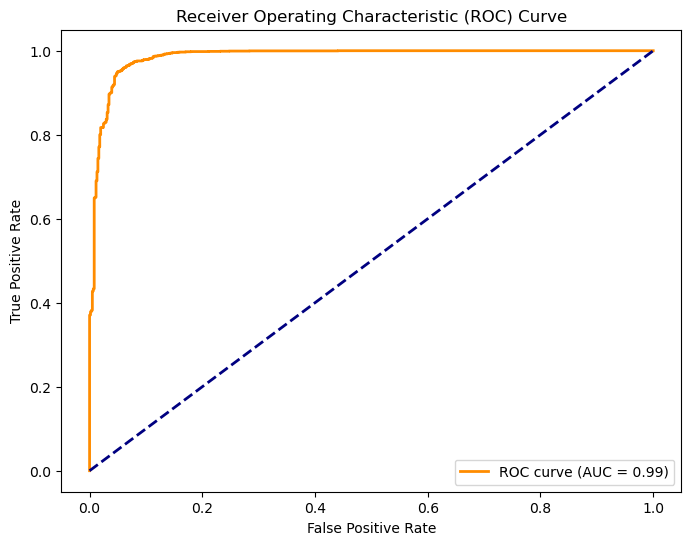

In [48]:
import matplotlib.pyplot as plt

# (Optional) Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()